In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})
import sklearn
print(sklearn.__version__)
%matplotlib inline

1.0.2


### Filter CVD Death Patients
Remove all the NON-CVD death patients. Here we take in input the original dataset and output the original dataset with only CVD Death patients:
- Input: data.csv
- Output: data_cvd.csv

In [2]:
# Load Data


df = pd.read_excel("data/raw/raw_data.xlsx",decimal=",", dtype=object)
data_prelievo = pd.read_excel("data/raw/data_prelievo.xlsx", decimal=',', dtype=object)
creatina = pd.read_excel("data/raw/creatina_more_columns.xlsx",decimal=",",dtype=object)
#old_df = pd.read_csv("/Users/donaldo/Documents/hearth-ml-old-project-unipi/ml4cad/data/raw/data_raw.csv",decimal=".", dtype=object, index_col=0)

#filtered = [x for x in df.columns if x not in old_df.columns]
#print(old_df.columns)
#old_in_df = [x for x in old_df.columns if x not in df.columns]
#print(old_in_df)
#print(df.columns)
print(f"{'Creatina' in df.columns}")
#print(f"{'Creatina' in old_df.columns}")
df.convert_dtypes()
data_prelievo.convert_dtypes()
creatina.convert_dtypes()
df = df.drop(columns = ["Total cholesterol","HDL","LDL","Triglycerides"])
print("Filtered")

#Drop unnecessary columns


False
Filtered


In [3]:

data_prelievo["Data prelievo"] = pd.to_datetime(data_prelievo["Data prelievo"], format="%m/%d/%Y")
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%m/%d/%Y")

# Remove blank rows
df = df[df["Number"].notna()]

df_length = len(df)
df_columns_length = len(df.columns)
# Inner join
df = pd.merge(df,data_prelievo, on="Number", how="inner", suffixes=("_left","_right"))
df = pd.merge(df,creatina, on="Number", how="inner", suffixes=("_left","_right"))

print(f"DF LENGTH {df_length}, DF AFTER MERGE LENGTH {len(df)}")
# Set the Number coloumn as default index
df = df.set_index("Number")
# I've added "Data Prelievo", "Creatina", "Total cholesterol","HDL","LDL" and "Triglycerides" columns
print(df_columns_length)
print(len(df.columns))
assert df_columns_length + 5 == len(df.columns)
assert df_length == len(df)

conflicts = df[df["Data prelievo"] > df["Follow Up Data"]]
assert len(conflicts) == 0

#print(df)
print("Dataset size:", len(df))

DF LENGTH 8065, DF AFTER MERGE LENGTH 8065
79
84
Dataset size: 8065


/opt/anaconda3/envs/ml_buzi/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [4]:
# Fill the NA values
# Move every vessels' value of 1, set the NA as 0

# Actually, it's not required, but I'll leave it to avoid unexpected behaviour if the dataset changes
df["Vessels"] += 1
df["Vessels"] = df["Vessels"].fillna(0)


In [5]:
# Remove ONLY and ALL the deaths patients NON-CVD (Fatal MI or Sudden death, UnKnown, Accident, Suicide)
total = df[df["Total mortality"]==1].index
cvd_idx = df[df["CVD Death"]==1].index
noncvd_idx = set(total) - set(cvd_idx)

print(f"Total deaths: {len(total)}")
print(f"Death CVD: {len(cvd_idx)}")
print(f"Death Non-CVD: {len(noncvd_idx)}")

df_cvd = df.drop(noncvd_idx)
print(f"\nTotal patients: {len(df)}")
print(f"Total patients (after removal of Death Non-CVD): {len(df_cvd)}")

assert len(noncvd_idx) == len(total) - len(cvd_idx)
assert len(df.columns) == len(df_cvd.columns)


# Filtered data set
df_cvd.to_csv("data/raw/data_cvd.csv")

Total deaths: 2406
Death CVD: 1008
Death Non-CVD: 1398

Total patients: 8065
Total patients (after removal of Death Non-CVD): 6667


### Clean Irrelevant Features
From the only CVD death patients, we remove all the irrelevant features for the classification task. We also create a target feature. 
- Input: data_cvd.csv
- Output: data_cvd_clean.csv

In [6]:
df_cvd = pd.read_csv("./data/raw/data_cvd.csv", index_col=0, decimal='.')
df_cvd["Follow Up Data"] = pd.to_datetime(df_cvd["Follow Up Data"])
df_cvd["Data prelievo"] = pd.to_datetime(df_cvd["Data prelievo"])

Text(0, 0.5, 'Patients')

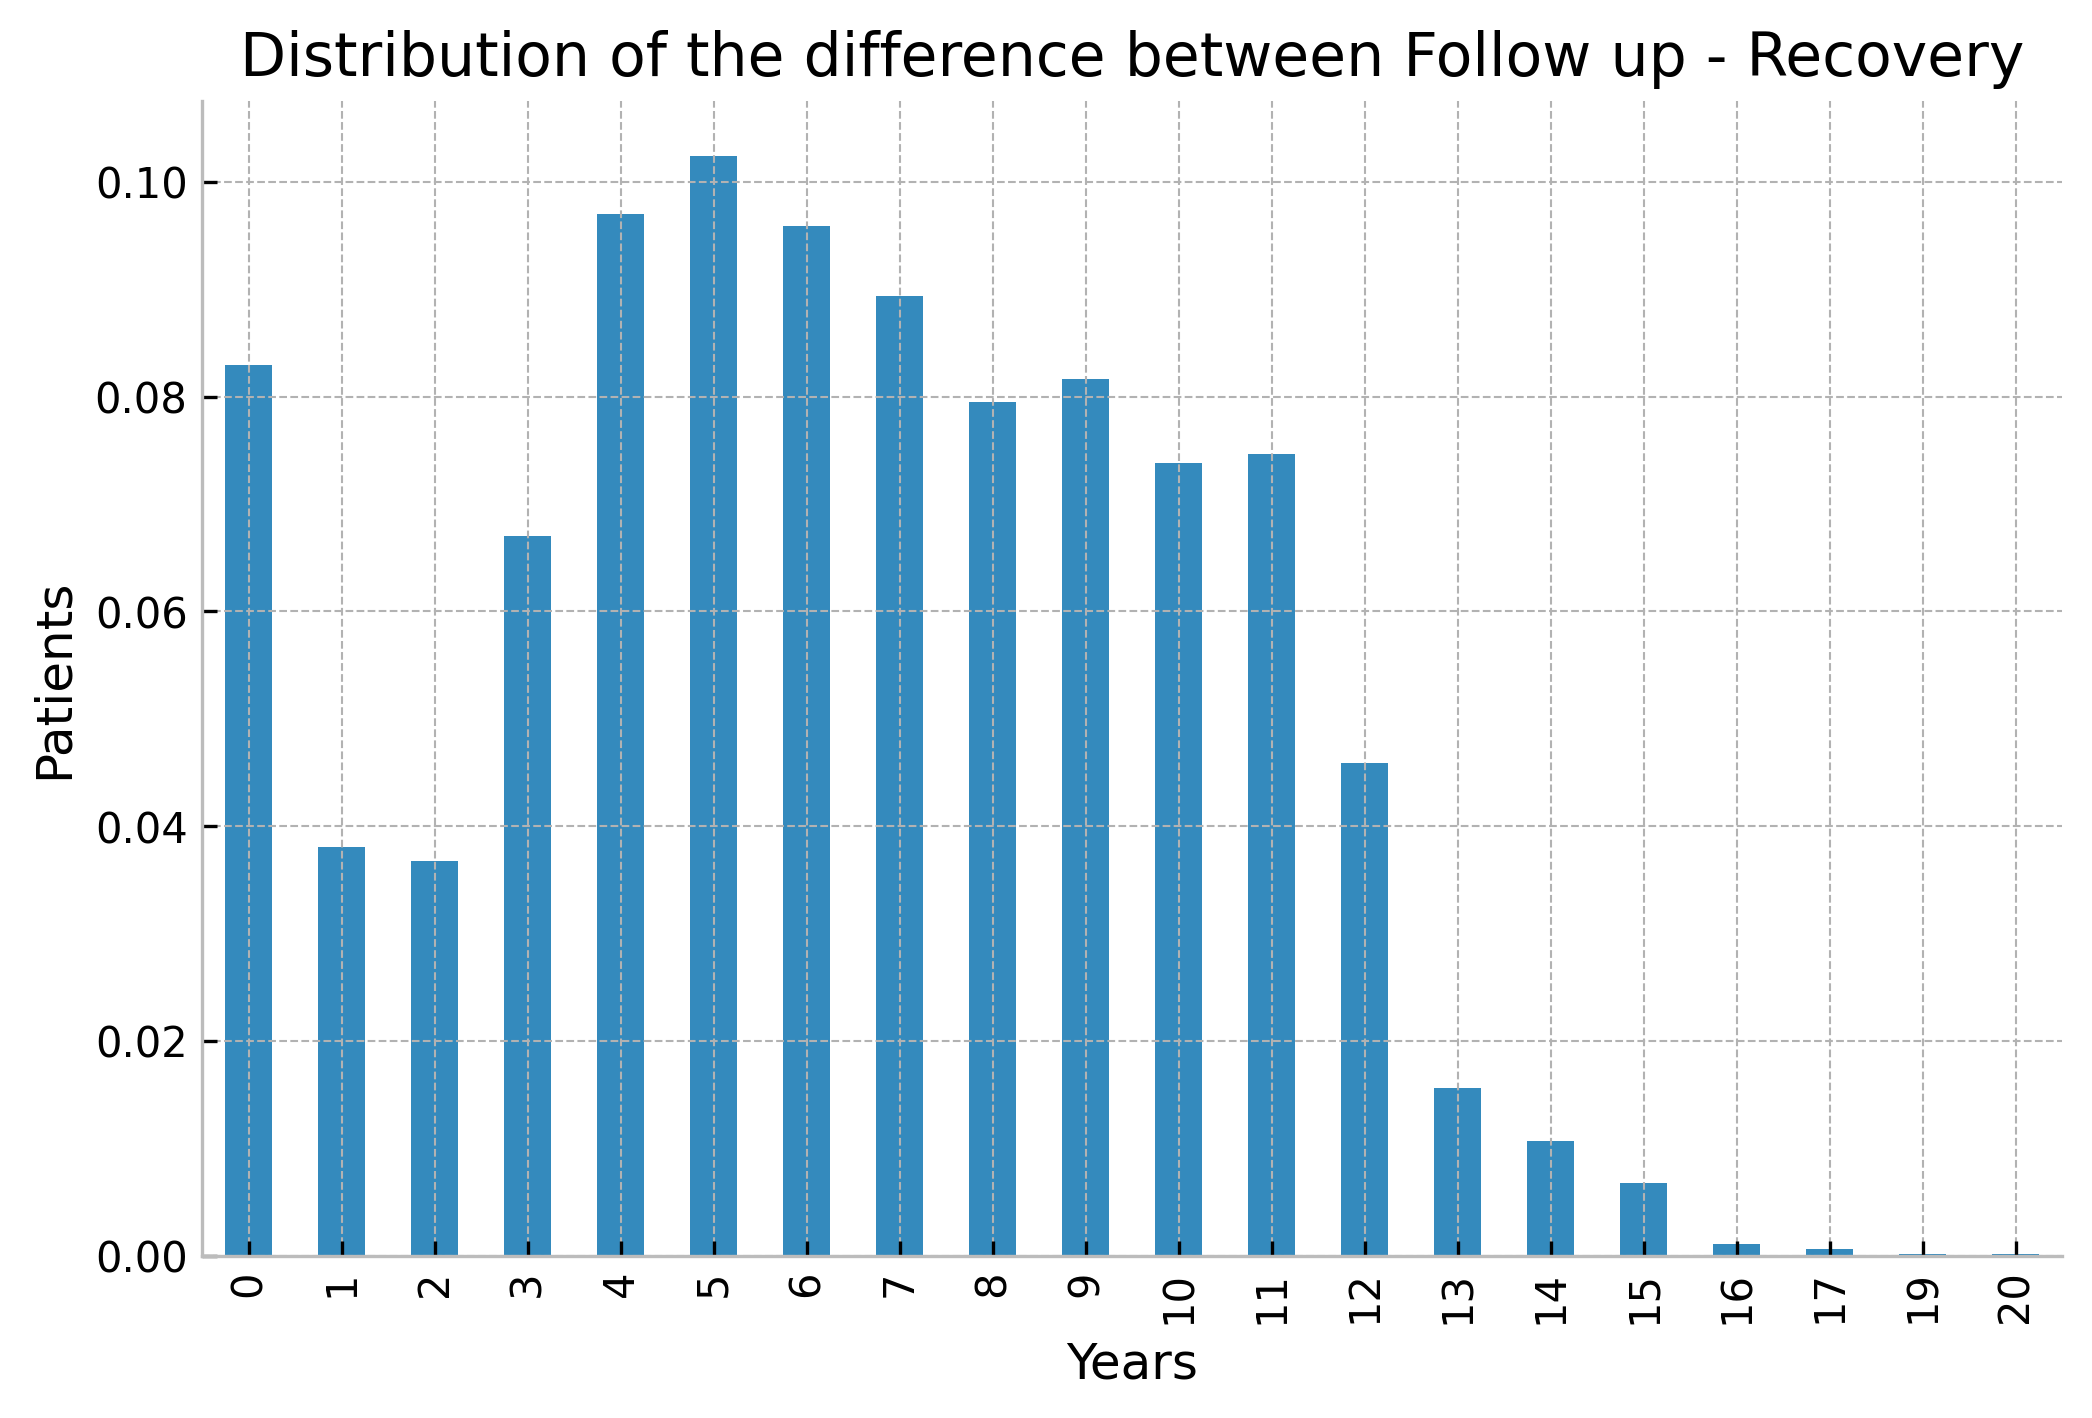

In [7]:
# Compute difference between dates: follow up and admission
figure = plt.figure()
df_diff = (df_cvd["Follow Up Data"] - df_cvd["Data prelievo"]).map(lambda x: x.days // 365)
df_diff.value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(8,5), ax=plt.gca())
plt.title("Distribution of the difference between Follow up - Recovery")
plt.xlabel("Years")
plt.ylabel("Patients")

In [10]:
# Complete vessels feature, if CAD == 0 then Vessels can be set to 0, otherwise we don't know the Vessels
for i in df_cvd.index:
    if (pd.isna(df_cvd["Vessels"][i]) and df_cvd["CAD"][i]==0):
        df_cvd.loc[i, "Vessels"] = 0
    elif (pd.isna(df_cvd["Vessels"][i]) and df_cvd["CAD"][i]==1):
        df_cvd.loc[i, "Vessels"] = -1

# Clean features remove follow up features
df_feat = df_cvd.copy()
# Thyroid related columns, 9 columns.
thyroid_columns = ["TSH","fT3","fT4","Euthyroid","Subclinical primary hypothyroidism (SCH)","Subclinical primary hyperthyroidism\n(SCT)","Low T3","Ipotiroidismo","Ipertiroidismo"]
# Remove columns that were not found within the old dataset
to_drop = ['Total cholesterol', 'HDL', 'LDL', 'Triglycerides', 'Glycemia', 'Primary Dilated\nCardiomyopathy', 'Normal', 'SindromeX', 'AMI', 'PMI', 'Aritmie', 'MIN', 'MIO', 'Miocardite', 'Pericardite', 'Endocardite', 'Valvulopatie', 'MalattiaVasoAorta', 'Ipertensione', 'CardiopatiaCongenita', 'EmboliaPolmonare', 'EPA', 'HR', 'Weight', 'Height', 'BMI', 'Diastolic blood pressure', 'Systolic blood pressure', 'WmsiBas', 'DimSettoIV', 'DimPP', 'vsx', 'B-Blockers', 'Amiodarone', 'Calcium channel blockers', 'Diuretics', 'Antiplatelet', 'Nitrates', 'ACE-inhibitors', 'Ipolipemizzanti', 'Antidiabetici', 'Cause of death', 'Collected by', 'Suicide', 'CABG ', 'Non Fatal AMI (Follow-Up)', 'Ictus', 'PCI']

# Not useful columns
df_feat = df_feat.drop(columns=["Data of death", "Data prelievo", "Follow Up Data",
                                "Fatal MI or Sudden death", "UnKnown", "Accident", "Total mortality", 
                                "CVD Death", "CAD", "Creatinina"])

# Create and add target feature `Survive`
years = 7
survive = (df_diff < years) & df_cvd["CVD Death"]
survive = (survive + 1) % 2
df_feat[f"Survive{years}Y"] = survive

df_with_thyroid = df_feat.drop(columns= to_drop)
df_without_thyroid = df_with_thyroid.copy().drop(columns = thyroid_columns)


print("Total patient: \t", len(df_feat))
print("Survived: \t", df_feat[f"Survive{years}Y"].sum(), "\t", df_feat[f"Survive{years}Y"].sum()/len(df_feat))
print("Dead: \t\t", len(df_feat)-df_feat[f"Survive{years}Y"].sum(), "\t", (len(df_feat)-df_feat[f"Survive{years}Y"].sum())/len(df_feat))
df_with_thyroid = df_with_thyroid.convert_dtypes()
df_without_thyroid = df_without_thyroid.convert_dtypes()

print(len(df_without_thyroid.columns))
assert len(df_with_thyroid.columns) == 28 - 1
assert len(df_without_thyroid.columns) == 19 - 1

df_with_thyroid.to_csv("data/thyroid/data_with_thyroid.csv")
df_without_thyroid.to_csv("data/no_thyroid/data_without_thyroid.csv")

Total patient: 	 6667
Survived: 	 5824 	 0.8735563221838908
Dead: 		 843 	 0.12644367781610918
18


### Extra
Create and save the subset datagroups

In [11]:
# dataset train, valid, test split
def split_and_save(df, path, verbose=True):
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.iloc[:,-1])
    df_train, df_valid = train_test_split(df_train, test_size=0.25, stratify=df_train.iloc[:,-1])

    df_train.to_csv(f"{path}train.csv")
    df_valid.to_csv(f"{path}valid.csv")
    df_test.to_csv(f"{path}test.csv")

    if verbose: 
        print("Train: \t", len(df_train))
        print("Valid: \t", len(df_valid))
        print("Test: \t", len(df_test))

split_and_save(df_with_thyroid, "data/thyroid/")
split_and_save(df_without_thyroid, "data/no_thyroid/")


Train: 	 3999
Valid: 	 1334
Test: 	 1334
Train: 	 3999
Valid: 	 1334
Test: 	 1334


In [ ]:
df_train = pd.read_csv("./data/7y/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/7y/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/7y/test.csv", index_col=0, decimal='.')

df_train_new = df_feat.loc[df_train.index, :]
df_valid_new = df_feat.loc[df_valid.index, :]
df_test_new = df_feat.loc[df_test.index, :]

path = "data"
df_train_new.to_csv(f"{path}/train.csv")
df_valid_new.to_csv(f"{path}/valid.csv")
df_test_new.to_csv(f"{path}/test.csv")

In [12]:
from collections import Counter

df_train = pd.read_csv("./data/thyroid/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/thyroid/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/thyroid/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))

df_train = pd.read_csv("./data/no_thyroid/train.csv", index_col=0, decimal='.')
df_valid = pd.read_csv("./data/no_thyroid/valid.csv", index_col=0, decimal='.')
df_test = pd.read_csv("./data/no_thyroid/test.csv", index_col=0, decimal='.')
print(Counter(df_train["Survive7Y"]))
print(Counter(df_valid["Survive7Y"]))
print(Counter(df_test["Survive7Y"]))

Counter({1: 3494, 0: 505})
Counter({1: 1165, 0: 169})
Counter({1: 1165, 0: 169})
Counter({1: 3494, 0: 505})
Counter({1: 1165, 0: 169})
Counter({1: 1165, 0: 169})
